In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

# Importing the modules themselves for reloading
import trading_bot.TradePosition
import trading_bot.TouchArea
import trading_bot.TradingStrategy
import trading_bot.TouchDetection
import trading_bot.TouchDetectionParameters
import trading_bot.MultiSymbolDataRetrieval
import trading_bot.TypedBarData
import trading_bot.VolumeProfile

# Reloading the modules to apply any changes
import importlib
importlib.reload(trading_bot.TradePosition)
importlib.reload(trading_bot.TouchArea)
importlib.reload(trading_bot.TradingStrategy)
importlib.reload(trading_bot.TouchDetection)
importlib.reload(trading_bot.TouchDetectionParameters)
importlib.reload(trading_bot.MultiSymbolDataRetrieval)
importlib.reload(trading_bot.TypedBarData)
importlib.reload(trading_bot.VolumeProfile)

from trading_bot.TradePosition import TradePosition, csv_to_trade_positions
from trading_bot.TradePositionPlotting import plot_cumulative_pl_and_price
from trading_bot.TouchArea import TouchArea
from trading_bot.TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 

from trading_bot.TouchDetection import calculate_touch_detection_area, plot_touch_detection_areas
from trading_bot.TouchDetectionParameters import BacktestTouchDetectionParameters, np_median, np_mean, get_latest_value
from trading_bot.MultiSymbolDataRetrieval import fill_missing_data

In [2]:
# symbol = "NVDA"
# symbol = "MSFT"
# symbol = "META"
# symbol = "AAPL"
# symbol = "TJX"
# symbol = "JNJ"
# symbol = "AMZN"
# symbol = "AZN"
# symbol = "TSLA"
# symbol = "TJX"
# symbol = "GOOGL"

# symbol = 'MSTR'
symbol = 'MARA'
# symbol = 'INTC'
# symbol = 'GOOG'


In [3]:
start_date = "2022-01-12 00:00:00"
end_date =   "2022-01-13 00:00:00"

# start_date = "2022-01-01 00:00:00"
# end_date =   "2022-02-01 00:00:00"

start_date = "2024-01-01 00:00:00"
# end_date =   "2024-08-17 00:00:00"
end_date =   "2024-09-27 00:00:00"

# start_date = "2017-01-01 00:00:00"
# end_date =   "2018-01-01 00:00:00"

start_date = "2024-07-01 00:00:00"
end_date =   "2024-08-01 00:00:00"

# start_date = "2024-08-01 00:00:00"
# end_date =   "2024-09-01 00:00:00"

# start_date = "2024-09-01 00:00:00"
# end_date =   "2024-10-01 00:00:00"

# start_date = "2024-10-01 00:00:00"
# end_date =   "2024-11-01 00:00:00"

# start_date = "2024-11-01 00:00:00"
# end_date =   "2024-12-01 00:00:00"

# start_date = "2024-12-01 00:00:00"
# end_date =   "2025-01-01 00:00:00"

# start_date = "2025-01-01 00:00:00"
# end_date =   "2025-02-01 00:00:00"

# start_date = "2024-09-04 00:00:00"
# end_date =   "2024-09-05 00:00:00"

start_date = "2024-12-06 00:00:00"
end_date =   "2024-12-07 00:00:00"

start_date = "2025-01-17 00:00:00"
end_date =   "2025-01-18 00:00:00"

# start_date = "2024-11-22 00:00:00"
# end_date =   "2024-11-23 00:00:00"

# Usage example:
touch_detection_params = BacktestTouchDetectionParameters(
    symbol=symbol,
    client_type='stock',
    start_date=start_date,
    end_date=end_date,
    # atr_period=15,
    # level1_period=15,
    # multiplier=1.4,
    min_touches=3,
    start_time='9:30',
    end_time='15:55',
    # end_time='11:20',
    # use_median=True,
    # touch_area_width_agg=get_latest_value,
    
    # ema_span=12,
    # price_ema_span=26,
    
    export_bars_path=f'bars/bars_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}.csv',
    export_quotes_path=f'quotes/quotes_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}.csv'
)

touch_detection_areas = calculate_touch_detection_area(touch_detection_params)

# touch_detection_areas = calculate_touch_detection_area(symbol, start_date, end_date, atr_period=15, level1_period=15, multiplier=1.4, min_touches=3, start_time=None, end_time='15:55', \
#     use_median=True, touch_area_width_agg=np_median,  export_bars_path=f'bars_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}.csv')


2025-02-18 06:22:34,630 - MultiSymbolDataRetrieval - INFO - Retrieved bars_MARA_2025-01-17_2025-01-18.csv from bars\bars_MARA_2025-01-17_2025-01-18.zip
2025-02-18 06:22:34,641 - MultiSymbolDataRetrieval - INFO - Retrieved bars_MARA_2025-01-17_2025-01-18_unadjusted.csv from bars\bars_MARA_2025-01-17_2025-01-18.zip
2025-02-18 06:22:35,141 - MultiSymbolDataRetrieval - INFO - Retrieved quotes for MARA from quotes\quotes_MARA_2025-01-17_2025-01-18.zip


In [4]:
# temp = touch_detection_areas.quotes.reset_index()
# temp['minute'] = temp.timestamp.apply(lambda x: pd.Timestamp(x).replace(second=0, microsecond=0))
# temp.groupby('minute').count()['symbol'].describe()

In [5]:
# temp.groupby('minute').count()['symbol']

In [6]:
def calculate_sorted_quote_changes(df):
    """
    Calculate and sort quote changes for each minute.
    
    :param df: DataFrame with (symbol, timestamp) multi-index and bid_price, ask_price columns
    :return: DataFrame with sorted quote changes
    """
    # Reset the index to make timestamp a column
    df = df.reset_index()

    # Convert timestamp to datetime if it's not already
    df['timestamp'] = pd.to_datetime(df['timestamp'])

    # Create a minute column
    df['minute'] = df['timestamp'].dt.floor('min')

    # Group by symbol and minute, then calculate the changes
    grouped = df.groupby(['symbol', 'minute'])
    changes = grouped.apply(lambda x: pd.Series({
        'bid_change': x['bid_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'ask_change': x['ask_price'].diff().iloc[-1] if len(x) > 1 else 0,
        'timestamp': x['timestamp'].iloc[0]  # Keep the timestamp of the first quote in the minute
    }))

    # Reset the index to make symbol and minute columns
    changes = changes.reset_index()

    # Sort by bid_change and ask_change in descending order
    changes_sorted = changes.sort_values(['bid_change', 'ask_change'], ascending=[False, False])

    return changes_sorted

# Example usage:
# sorted_changes = calculate_sorted_quote_changes(touch_detection_areas.quotes)
# sorted_changes

In [7]:
# times = touch_detection_areas.bars.index.get_level_values('timestamp').time
# print(touch_detection_areas.bars.loc[(times >= time(9,30)) & (times <= time(16,0))])

In [8]:
# print(touch_detection_areas.quotes_raw)

In [9]:
# print(touch_detection_areas.quotes_agg)

In [10]:

def plot_quote_changes_histogram(sorted_changes, num_bins=50):
    """
    Create histograms of bid and ask price changes.
    
    :param sorted_changes: DataFrame returned by calculate_sorted_quote_changes function
    :param num_bins: Number of bins for the histogram (default: 50)
    """
    # Create a figure with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12))
    
    # Plot histogram of bid changes
    ax1.hist(sorted_changes['bid_change'], bins=num_bins, edgecolor='black')
    ax1.set_title('Histogram of Bid Price Changes')
    ax1.set_xlabel('Bid Price Change')
    ax1.set_ylabel('Frequency')
    
    # Plot histogram of ask changes
    ax2.hist(sorted_changes['ask_change'], bins=num_bins, edgecolor='black')
    ax2.set_title('Histogram of Ask Price Changes')
    ax2.set_xlabel('Ask Price Change')
    ax2.set_ylabel('Frequency')
    
    # Adjust layout and display the plot
    plt.tight_layout()
    plt.show()
# plot_quote_changes_histogram(sorted_changes)

In [11]:
# sorted_changes.describe()

In [12]:
# (touch_detection_areas.bars[touch_detection_areas.mask]['avg_volume_2'] == touch_detection_areas.bars[touch_detection_areas.mask]['avg_volume_3']).value_counts()

In [13]:
touch_detection_areas.bars[touch_detection_areas.mask][['volume']+[a for a in touch_detection_areas.bars.columns if a.startswith('avg_volume')]]

volume     avg_volume
symbol timestamp                                         
MARA   2025-01-17 09:30:00-05:00   16165.0    9818.328541
       2025-01-17 09:31:00-05:00  713501.0  118077.201073
       2025-01-17 09:32:00-05:00  551561.0  184767.016292
       2025-01-17 09:33:00-05:00  504539.0  233962.706094
       2025-01-17 09:34:00-05:00  611359.0  292023.674387
...                                    ...            ...
       2025-01-17 15:51:00-05:00  182355.0  150921.421606
       2025-01-17 15:52:00-05:00  131412.0  147919.972128
       2025-01-17 15:53:00-05:00  592221.0  216273.976416
       2025-01-17 15:54:00-05:00  203418.0  214296.133891
       2025-01-17 15:55:00-05:00  359798.0  236681.036369

[386 rows x 2 columns]

In [14]:
print(touch_detection_areas.bars[touch_detection_areas.mask].columns.to_list())

['open', 'high', 'low', 'close', 'volume', 'trade_count', 'vwap', 'MACD', 'MACD_signal', 'MACD_hist', 'MACD_hist_roc', 'RSI', 'RSI_roc', 'MFI', 'MFI_roc', 'VWAP', 'VWAP_dist', 'VWAP_std', 'VWAP_std_close', 'central_value', 'central_value_dist', 'exit_ema', 'exit_ema_dist', 'is_res', 'H_L', 'ATR', 'MTR', 'avg_volume', 'avg_trade_count', 'log_return', 'volatility', 'rolling_range_min_4', 'rolling_range_min_7', 'rolling_ATR', 'ADX', 'trend_strength']


In [15]:
# touch_detection_areas.bars[touch_detection_areas.mask].reset_index().to_csv('asdf2.csv',index=False)
# touch_detection_areas.bars.reset_index().to_csv('asdfasdf.csv',index=False)

In [16]:
# a = touch_detection_areas.bars[touch_detection_areas.mask]['trade_count'].astype(float).describe()
# b = touch_detection_areas.bars[touch_detection_areas.mask]['volume'].astype(float).describe()
# c = touch_detection_areas.bars[touch_detection_areas.mask]['shares_per_trade'].astype(float).describe()
# pd.concat([a,b,c],axis=1)

In [17]:
# # zoom_start_date = start_date
# # zoom_end_date = end_date
# zoom_start_date = "2024-12-10 00:00:00"
# zoom_end_date =   "2024-12-12 00:00:00"
# plot_touch_detection_areas(touch_detection_areas)
# plot_touch_detection_areas(touch_detection_areas, zoom_start_date, zoom_end_date)

In [18]:
len(touch_detection_areas.long_touch_area) + len(touch_detection_areas.short_touch_area)

29

In [19]:
# print(touch_detection_areas.rsi_overbought)
# print(touch_detection_areas.rsi_oversold)

2025-02-18 06:22:36,789 - TradingStrategy - INFO - Starting balance on 2025-01-17: 30000


MARA is marginable.
MARA is shortable and ETB.


2025-02-18 06:22:39,231 - TradingStrategy - INFO - 09:31, price 19.1600, H-L 19.2799-19.0700, LATEST QUOTE: 09:30:59.725294 19.16 19.17:
2025-02-18 06:22:39,239 - TradingStrategy - INFO - 09:32, price 19.1450, H-L 19.2150-18.9600, LATEST QUOTE: 09:31:59.848679 19.14 19.15:
2025-02-18 06:22:39,245 - TradingStrategy - INFO - 09:33, price 19.3700, H-L 19.3800-19.1300, LATEST QUOTE: 09:32:59.991075 19.37 19.38:
2025-02-18 06:22:39,250 - TradingStrategy - INFO - 09:34, price 19.4500, H-L 19.5100-19.3600, LATEST QUOTE: 09:33:59.627020 19.44 19.45:
2025-02-18 06:22:39,255 - TradingStrategy - INFO - 09:35, price 19.4350, H-L 19.4500-19.3400, LATEST QUOTE: 09:34:59.988253 19.43 19.44:
2025-02-18 06:22:39,261 - TradingStrategy - INFO - 09:36, price 19.5300, H-L 19.5500-19.3400, LATEST QUOTE: 09:35:59.799520 19.52 19.53:
2025-02-18 06:22:39,267 - TradingStrategy - INFO - 09:37, price 19.4776, H-L 19.5900-19.4340, LATEST QUOTE: 09:36:59.955728 19.46 19.47:
2025-02-18 06:22:39,273 - TradingStrategy

END
Strategy: Long&Short
MARA is marginable.
MARA is shortable and ETB.
2025-01-17 09:30:00-05:00 -> 2025-01-17 15:55:00-05:00

Overall Statistics:
Initial Investment:       $30,000.00
Initial Buying Power:     $30,000.00
Margin Multiplier:       1.00x
Final Buying Power:       $30,052.80
Buying Power % Change:   0.18%
Final Cash Balance:      $30,052.80
Cash Balance % Change:  0.18%
Baseline % change:  4.2991%
Number of Trades Executed: 6
Simultaneous close and open count: 1

Total Profit/Loss (after fees): $52.7951
  Total Profit: $101.6835
  Total Loss:   $-48.8884
Total Transaction Costs: $9.7252
  Borrow Fees: $0.0064
  Commission: $8.8960
Value lost to slippage: $11.8798

Average Profit/Loss per Trade (after fees): $8.7992

Detailed Trade Statistics:
Statistic            25%       50%       75%  count freq       max      mean  \
Trade Category                                                                 
All            -0.675395 -0.151412   0.56158      6  NaN  0.957755 -0.036

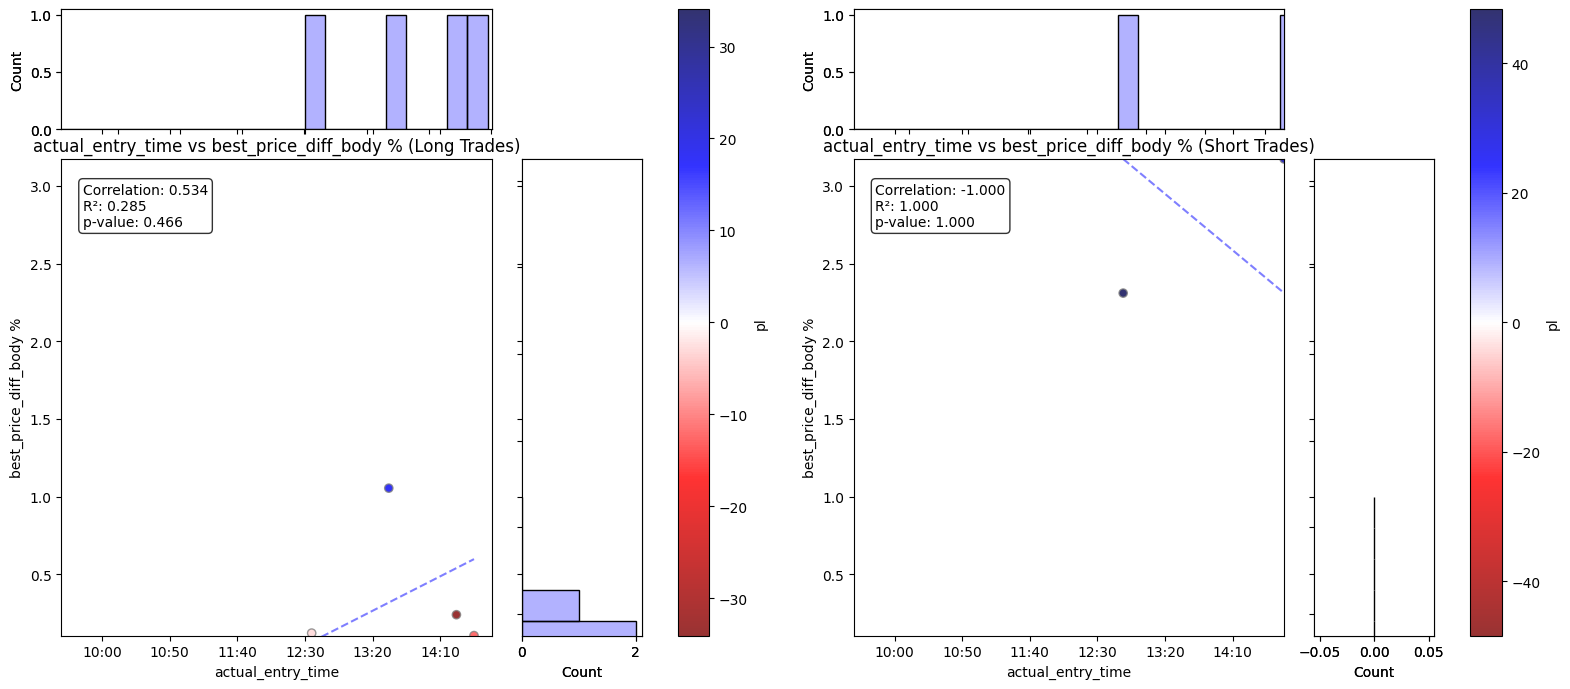

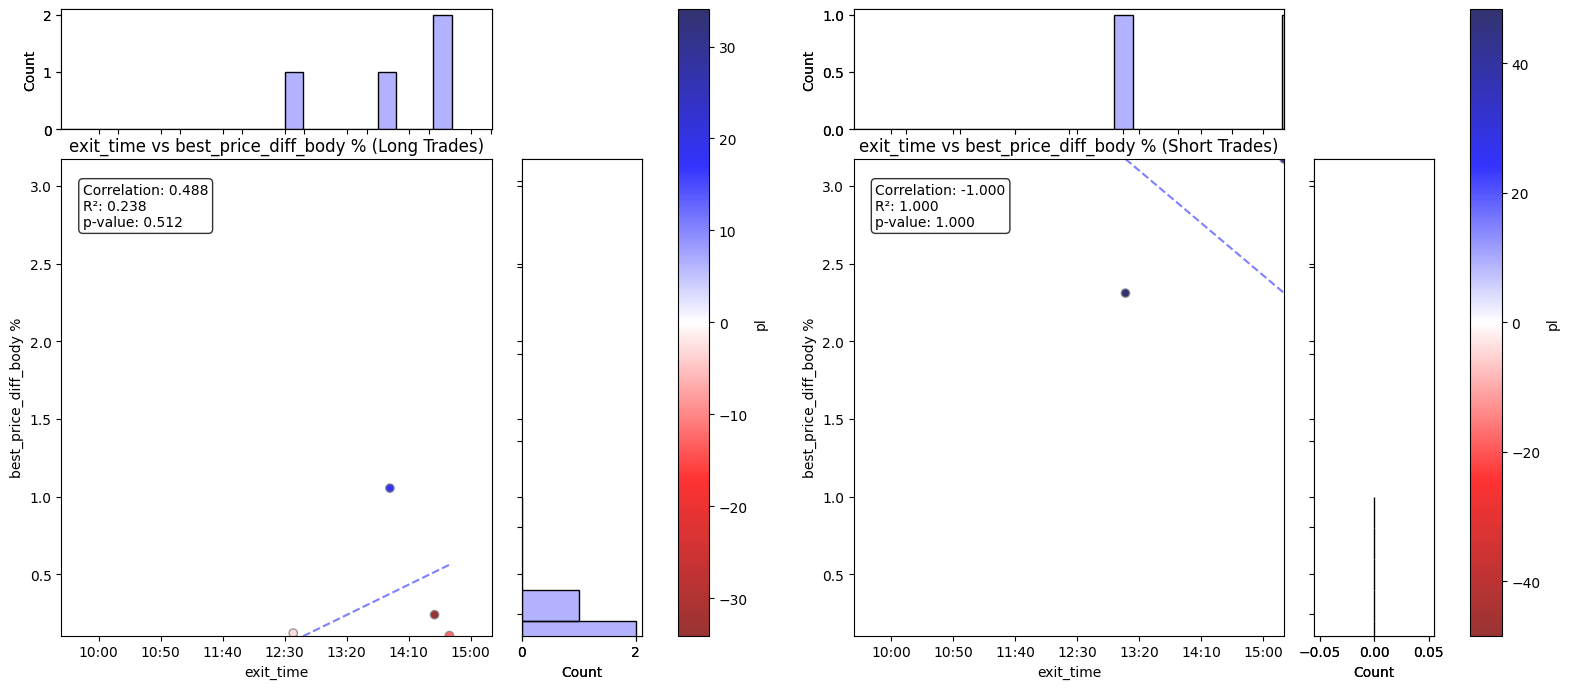

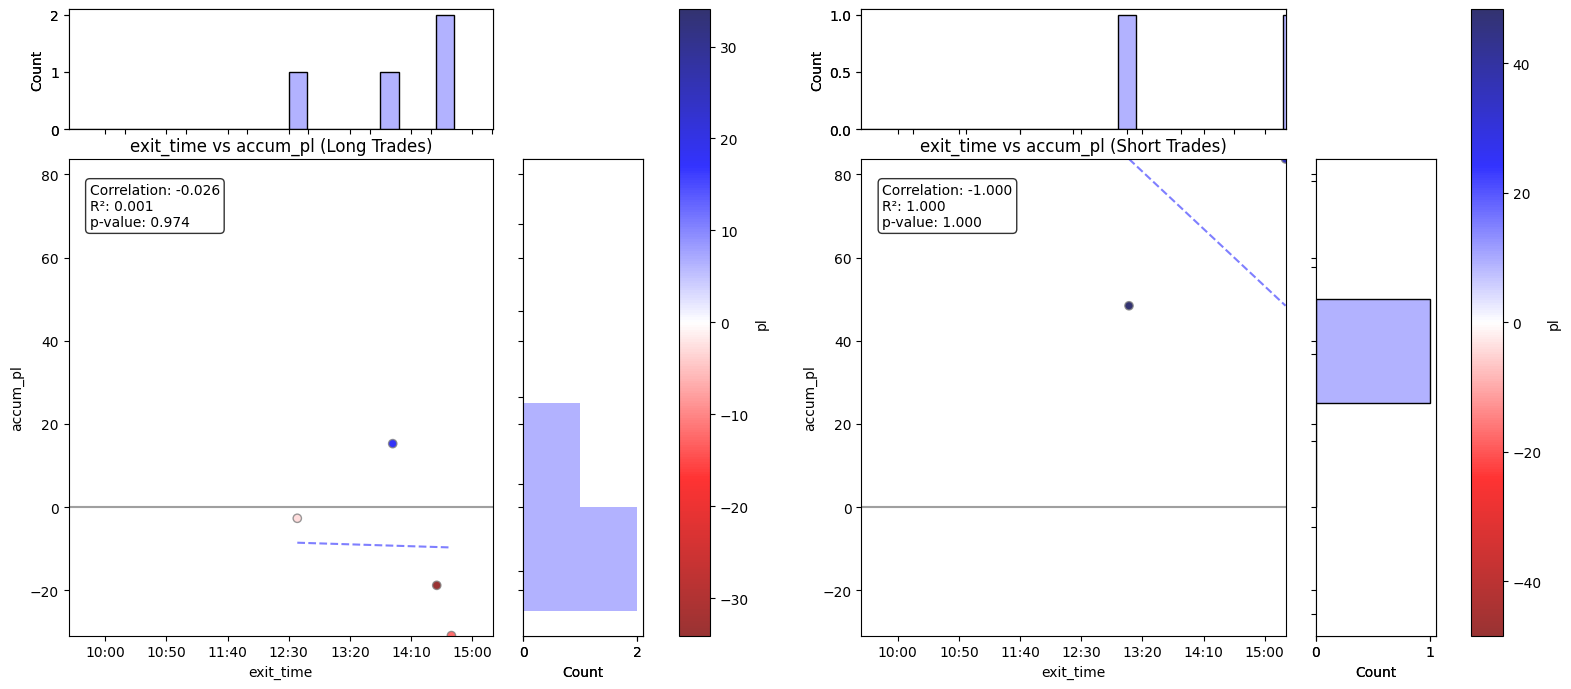

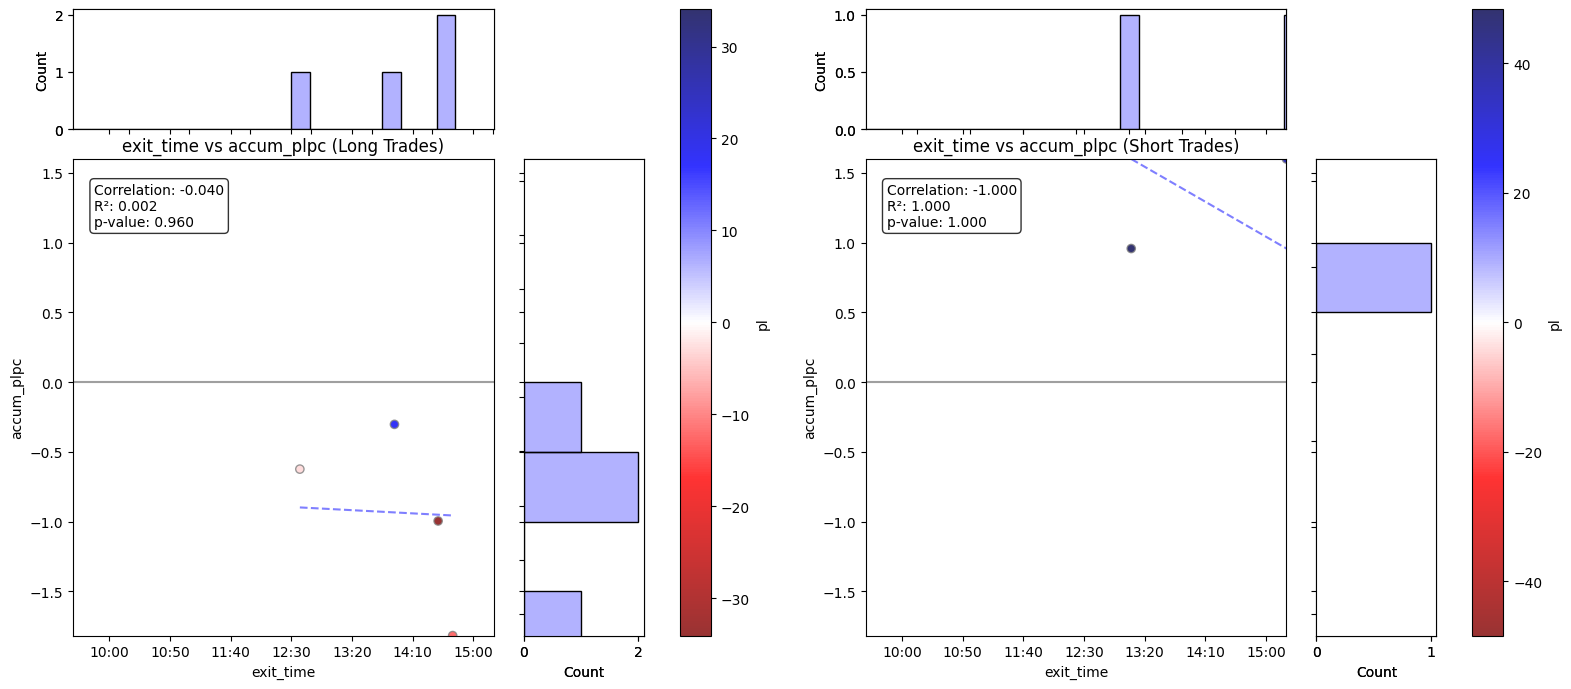

In [20]:

import trading_bot.TouchArea
import trading_bot.TradingStrategy
import trading_bot.TradingStrategyParameters
import trading_bot.TouchDetection
import trading_bot.TradePosition
import trading_bot.TypedBarData
import trading_bot.VolumeProfile

import importlib
importlib.reload(trading_bot.TradingStrategy)
importlib.reload(trading_bot.TradingStrategyParameters)
importlib.reload(trading_bot.TouchDetection)
importlib.reload(trading_bot.TradePosition)
importlib.reload(trading_bot.TouchArea)
importlib.reload(trading_bot.TypedBarData)
importlib.reload(trading_bot.VolumeProfile)

from trading_bot.TradingStrategy import StrategyParameters, TouchDetectionAreas, TradingStrategy 
from trading_bot.TouchDetection import *



strategy_params = StrategyParameters(
    initial_investment=30_000,
    max_investment=30_000,

    do_longs=True,
    do_shorts=True,
    sim_longs=True,
    sim_shorts=True,
    
    use_margin=True,
    
    assume_marginable_and_etb=True,
    
    times_buying_power=1,
    
    soft_start_time = '09:30', 
    soft_end_time = '15:30',
    
    # plot_day_results=True,
    # plot_volume_profiles=True,
    
    # allow_reversal_detection=True, # False (no switching) seems better for more stocks. If True, clear_passed_areas=True might improve performance.
    
    clear_passed_areas=True,

    # ### OUTDATED ### False is better for meme stocks, True better for mid and losing stocks (reduces losses). ### OUTDATED ###
    
    # True is better for meme stocks, False better for mid and losing stocks (reduces losses).
    
    clear_traded_areas=True,
    # True is better/safer for meme/mid?
    
    
    
    # min_stop_dist_relative_change_for_partial=1,
    
    
    # volume_profile_ema_span=np.inf,
    # volume_profile_ema_span=240,
    # volume_profile_ema_span=390,
    gradual_entry_range_multiplier = 1.8
    
)

# strategy_params.slippage.slippage_factor=1  # default is 0.02
strategy_params.ordersizing.max_volume_percentage = 0.2 # %. default is 1 %
# strategy_params.slippage.slippage_factor = 0

# export_graph_name = f"trades_pl_graphs_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}"
export_trades_name = f"trades_output_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}"
export_graph_name = f"graph_{symbol.replace('/','-')}_{start_date.split()[0]}_{end_date.split()[0]}"
folder_name = f"example backtesting results output"
strategy = TradingStrategy(touch_detection_areas, strategy_params, log_level=logging.INFO, export_trades_path=f'{folder_name}/{export_trades_name}.csv',
                           export_graph_path=f'{folder_name}/{export_graph_name}.png')
# strategy = TradingStrategy(touch_detection_areas, strategy_params, export_trades_path=f'trades_output_{symbol.replace('/','-')} get_latest_value 1.725.csv')
results = strategy.run_backtest()

In [21]:
# Specify the metrics to include
metrics_to_include = ['count', 'mean', 'std', 'min', '25%', '50%', '75%', 'max']
columns_to_exclude = ['ID', 'AreaID', 'date', 'Entry Time', 'Exit Time', 'open', 'high', 'low', 'close', 'Entry Price', 'Exit Price', 'vwap', 'Times Buying Power']

# Add non-numeric columns to exclusion list
non_numeric_cols = results.select_dtypes(exclude=['float64', 'float32', 'int64', 'int32']).columns
columns_to_exclude.extend(non_numeric_cols)
columns_to_exclude.remove('Side Win Lose')

# Create custom describe function that excludes NaN values in counts
def custom_describe(group):
    return pd.DataFrame({
        col: {
            'count': group[col].count(),  # Counts non-NaN values
            'mean': group[col].mean(),
            'std': group[col].std(),
            'min': group[col].min(),
            '25%': group[col].quantile(0.25),
            '50%': group[col].quantile(0.50),
            '75%': group[col].quantile(0.75),
            'max': group[col].max()
        } for col in group.columns
    })

# Compute the descriptive statistics and filter
custom_describe_df = results.drop(columns=columns_to_exclude, errors='ignore') \
    .groupby('Side Win Lose') \
    .apply(custom_describe)

# Filter out metrics not in the desired list
filtered_describe = custom_describe_df.loc[custom_describe_df.index.get_level_values(1).isin(metrics_to_include)]
filtered_describe = filtered_describe.reset_index().rename(columns={'level_1':'func'})

# Split Side Win Lose into separate columns
temp = filtered_describe['Side Win Lose']
filtered_describe.insert(1, 'Side', temp.str.split().str[0])
filtered_describe.insert(2, 'WinLose', temp.str.split().str[1])

# Convert WinLose to Categorical with custom order
filtered_describe['WinLose'] = pd.Categorical(
    filtered_describe['WinLose'], 
    categories=['Win', 'Lose', 'Unentered'], 
    ordered=True
)

# Sort with categorical column
filtered_describe.sort_values(
    by=['Side', 'WinLose'], 
    ascending=[True, True], 
    inplace=True
)

filtered_describe = filtered_describe.round(2)

# Add function to Side Win Lose for Excel freezing
filtered_describe['Side Win Lose'] = filtered_describe['Side Win Lose'] + ' ' + filtered_describe['func']

# Split into two dataframes based on 'func'
stats_df = filtered_describe[filtered_describe['func'] != 'count']
counts_df = filtered_describe[filtered_describe['func'] == 'count']

# Concatenate with empty row in between
final_df = pd.concat([stats_df, pd.DataFrame(columns=filtered_describe.columns, index=[0]), counts_df], ignore_index=True)

# Save to CSV
final_df.to_csv(f'{folder_name}/{export_trades_name.replace('trades_output','trades_stats')}.csv', index=False)
final_df

C:\Users\alexw\AppData\Local\Temp\ipykernel_18956\638809500.py:63: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final_df = pd.concat([stats_df, pd.DataFrame(columns=filtered_describe.columns, index=[0]), counts_df], ignore_index=True)


,Side Win Lose,Side,WinLose,func,total_tp_exits,Avg Entry Price,Num Transact,Last Max Shares,Initial Qty,Target Qty,...,buy_vol_kurtosis,buy_hvn_balance,buy_hvn_concentration,buy_hvn_avg_prominence,sell_vol_balance,sell_vol_concentration,sell_vol_kurtosis,sell_hvn_balance,sell_hvn_concentration,sell_hvn_avg_prominence
0,Long Win mean,Long,Win,mean,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
1,Long Win std,Long,Win,std,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Long Win min,Long,Win,min,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
3,Long Win 25%,Long,Win,25%,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
4,Long Win 50%,Long,Win,50%,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
5,Long Win 75%,Long,Win,75%,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
6,Long Win max,Long,Win,max,2.00,20.81,8.00,54.00,7.00,269.00,...,-2.55,-1.00,0.81,0.0,-0.44,0.39,-2.60,-1.00,0.81,0.0
7,Long Lose mean,Long,Lose,mean,0.33,20.79,4.33,263.33,27.33,268.33,...,-2.52,-0.54,0.86,0.0,-0.26,0.38,-2.59,-0.45,0.85,0.0
8,Long Lose std,Long,Lose,std,0.58,0.13,2.08,56.32,5.69,50.96,...,0.44,0.79,0.04,0.0,0.26,0.03,0.37,0.91,0.05,0.0
9,Long Lose min,Long,Lose,min,0.00,20.72,2.00,220.00,21.00,235.00,...,-2.87,-1.00,0.83,0.0,-0.43,0.35,-2.89,-1.00,0.80,0.0


C:\Users\alexw\AppData\Local\Temp\ipykernel_18956\3400531248.py:21: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Switched'] = df['Type'].str.startswith('*')
C:\Users\alexw\AppData\Local\Temp\ipykernel_18956\3400531248.py:22: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['Original_Type'] = df.apply(get_original_type, axis=1)
C:\Users\alexw\AppData\Local\Temp\ipykernel_18956\3400531248.py:25: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor


=== Trading Performance Analysis ===

Overall Performance:
                       ROE (P/L %)                         holding_time  \
                             count  mean   std   min   max         mean   
Original_Type Switched                                                    
Long          False              4 -0.45  0.52 -0.82  0.32         10.5   
Short         False              2  0.80  0.22  0.64  0.96         24.5   

                       Profitable_Time_Ratio body_above_buy_price_time  
                                        mean                      mean  
Original_Type Switched                                                  
Long          False                    10.39                      8.25  
Short         False                    94.05                     25.50  

Efficiency Analysis:
              Efficiency_Body        Efficiency_Wick        max_pl_body_time  \
                         mean    std            mean    std             mean   
Original_Type    

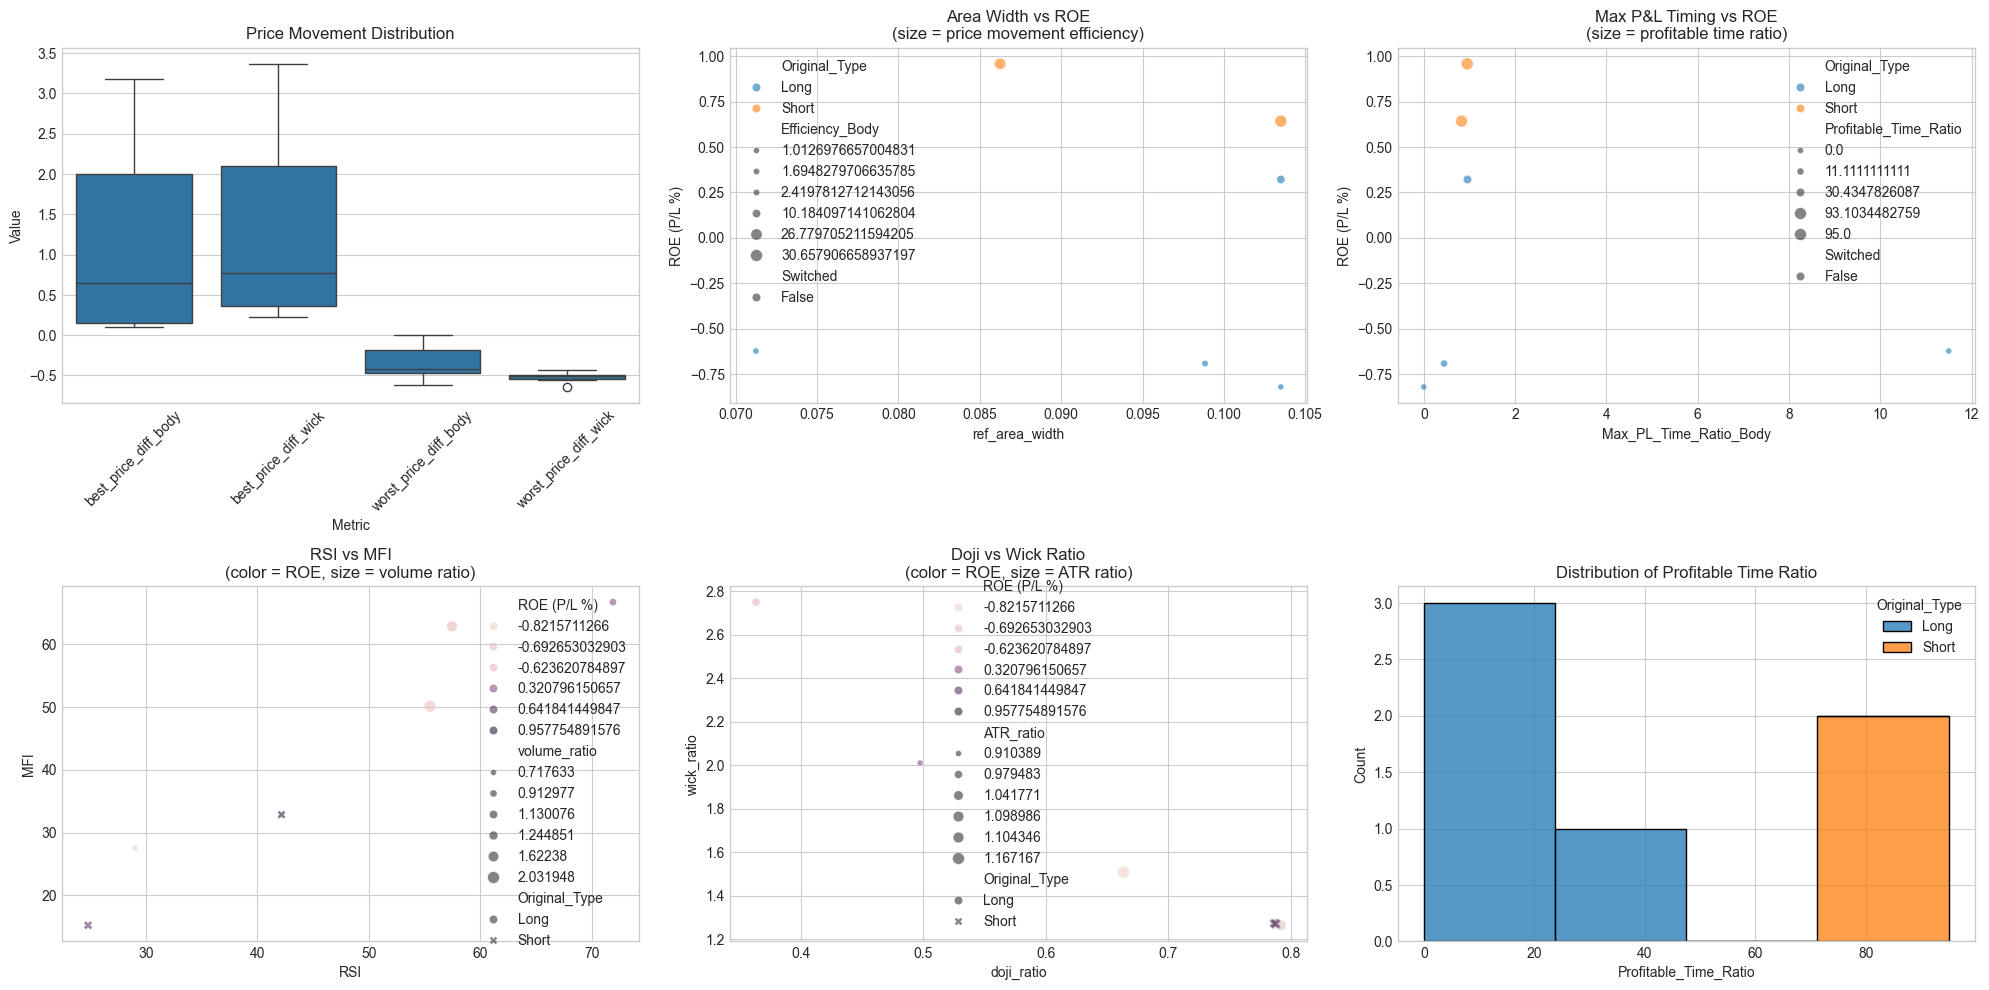

In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import spearmanr
import statsmodels.api as sm

def get_original_type(row):
    """If type starts with *, return the original type (opposite of what follows)."""
    if row['Type'].startswith('*'):
        return 'Short' if row['Type'].endswith('Long') else 'Long'
    return row['Type']

def analyze_trading_performance(df):
    """
    Analyze trading performance with focus on price movement patterns,
    holding time characteristics, and area behavior.
    """
    # Add indicator for switched areas and original type
    df['Switched'] = df['Type'].str.startswith('*')
    df['Original_Type'] = df.apply(get_original_type, axis=1)
    
    # Calculate efficiency metrics
    df['Efficiency_Body'] = df['best_price_diff_body'] / df['ref_area_width']
    df['Efficiency_Wick'] = df['best_price_diff_wick'] / df['ref_area_width']
    df['Max_PL_Time_Ratio_Body'] = df['max_pl_body_time'] / df['holding_time']
    df['Max_PL_Time_Ratio_Wick'] = df['max_pl_wick_time'] / df['holding_time']
    df['Profitable_Time_Ratio'] = df['profitable_time_pct']
    
    # Setup plotting
    plt.style.use('seaborn-v0_8-whitegrid')
    fig = plt.figure(figsize=(20, 15))
    
    # 1. Price Movement Analysis
    plt.subplot(3, 3, 1)
    plot_data = pd.melt(df, 
                        value_vars=['best_price_diff_body', 'best_price_diff_wick',
                                  'worst_price_diff_body', 'worst_price_diff_wick'],
                        var_name='Metric', value_name='Value')
    sns.boxplot(data=plot_data, x='Metric', y='Value')
    plt.title('Price Movement Distribution')
    plt.xticks(rotation=45)
    
    # 2. Efficiency Analysis
    plt.subplot(3, 3, 2)
    sns.scatterplot(data=df, x='ref_area_width', y='ROE (P/L %)',
                    hue='Original_Type', size='Efficiency_Body',
                    style='Switched', alpha=0.6)
    plt.title('Area Width vs ROE\n(size = price movement efficiency)')
    
    # 3. Timing Analysis
    plt.subplot(3, 3, 3)
    sns.scatterplot(data=df, x='Max_PL_Time_Ratio_Body', y='ROE (P/L %)',
                    hue='Original_Type', size='Profitable_Time_Ratio',
                    style='Switched', alpha=0.6)
    plt.title('Max P&L Timing vs ROE\n(size = profitable time ratio)')
    
    # 4. Technical Indicator Analysis
    plt.subplot(3, 3, 4)
    sns.scatterplot(data=df, x='RSI', y='MFI',
                    hue='ROE (P/L %)', size='volume_ratio',
                    style='Original_Type', alpha=0.6)
    plt.title('RSI vs MFI\n(color = ROE, size = volume ratio)')
    
    # 5. Price Pattern Analysis
    plt.subplot(3, 3, 5)
    sns.scatterplot(data=df, x='doji_ratio', y='wick_ratio',
                    hue='ROE (P/L %)', size='ATR_ratio',
                    style='Original_Type', alpha=0.6)
    plt.title('Doji vs Wick Ratio\n(color = ROE, size = ATR ratio)')
    
    # 6. Distribution of Profitability Timing
    plt.subplot(3, 3, 6)
    sns.histplot(data=df, x='Profitable_Time_Ratio',
                 hue='Original_Type', multiple="stack")
    plt.title('Distribution of Profitable Time Ratio')
    
    # Statistical Analysis
    print("\n=== Trading Performance Analysis ===\n")
    
    # Overall performance
    print("Overall Performance:")
    overall_stats = df.groupby(['Original_Type', 'Switched']).agg({
        'ROE (P/L %)': ['count', 'mean', 'std', 'min', 'max'],
        'holding_time': 'mean',
        'Profitable_Time_Ratio': 'mean',
        'body_above_buy_price_time': 'mean',
    }).round(2)
    print(overall_stats)
    
    # Efficiency analysis
    print("\nEfficiency Analysis:")
    efficiency_stats = df.groupby('Original_Type').agg({
        'Efficiency_Body': ['mean', 'std'],
        'Efficiency_Wick': ['mean', 'std'],
        'max_pl_body_time': ['mean', 'std']
    }).round(3)
    print(efficiency_stats)
    
    # Area behavior
    print("\nArea Behavior:")
    area_stats = df.groupby('Original_Type').agg({
        'ref_area_width': 'mean',
        'body_above_buy_price_time': ['mean', 'std']
    }).round(3)
    print(area_stats)
    
    # Correlation with performance
    print("\nCorrelations with ROE:")
    perf_indicators = ['best_price_diff_body', 'best_price_diff_wick',
                      'Efficiency_Body', 'Profitable_Time_Ratio',
                      'RSI', 'MFI', 'volume_ratio', 'ATR_ratio']
    
    for indicator in perf_indicators:
        coef, p_value = spearmanr(df[indicator], df['ROE (P/L %)'])
        print(f"{indicator:20} coef = {coef:6.3f}, p = {p_value:6.3f}")
    
    # Switched vs non-switched effectiveness
    print("\nSwitched vs Non-switched Performance:")
    switch_stats = df.groupby(['Original_Type', 'Switched']).agg({
        'ROE (P/L %)': ['mean', 'std'],
        'Profitable_Time_Ratio': 'mean'
    }).round(3)
    print(switch_stats)
    
    plt.tight_layout()
    return fig

# Example usage:
df = pd.read_csv(f'{folder_name}/{export_trades_name}.csv')
fig = analyze_trading_performance(df)
plt.show()

In [23]:
df.columns

Index(['sym', 'date', 'ID', 'AreaID', 'Type', 'Commit Time', 'Entry Time',
       'Exit Time', 'total_tp_exits', 'last_tp_exit_time',
       ...
       'sell_hvn_balance', 'sell_hvn_concentration', 'sell_hvn_avg_prominence',
       'Switched', 'Original_Type', 'Efficiency_Body', 'Efficiency_Wick',
       'Max_PL_Time_Ratio_Body', 'Max_PL_Time_Ratio_Wick',
       'Profitable_Time_Ratio'],
      dtype='object', length=146)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.preprocessing import StandardScaler

def analyze_macd_confirmation(df):
    """
    Analyze potential MACD-based confirmation signals for trade switching.
    """
    # Create success flag (1 for profitable trades)
    df['Success'] = (df['Total P/L'] > 0).astype(int)
    
    # Create categorical variables for indicator conditions
    df['MACD_Direction'] = np.where(df['MACD'] > 0, 'Positive', 'Negative')
    df['MACD_Signal_Cross'] = np.where(df['MACD'] > df['MACD_signal'], 'Above', 'Below')
    df['MACD_Hist_Direction'] = np.where(df['MACD_hist'] > 0, 'Positive', 'Negative')
    df['MACD_Hist_ROC_Direction'] = np.where(df['MACD_hist_roc'] > 0, 'Increasing', 'Decreasing')
    
    # Separate analyses for overbought and oversold conditions
    df['RSI_Condition'] = pd.cut(df['RSI'], 
                                bins=[0, 30, 70, 100],
                                labels=['Oversold', 'Neutral', 'Overbought'])
    
    # Calculate success rates for different indicator combinations
    conditions = ['MACD_Direction', 'MACD_Signal_Cross', 'MACD_Hist_Direction', 'MACD_Hist_ROC_Direction']
    
    results = []
    for condition in conditions:
        for rsi_zone in ['Oversold', 'Overbought']:
            mask = df['RSI_Condition'] == rsi_zone
            success_rates = df[mask].groupby([condition, 'Original_Type'])['Success'].agg(['count', 'mean'])
            success_rates = success_rates.round(4)
            for idx, row in success_rates.iterrows():
                results.append({
                    'RSI_Zone': rsi_zone,
                    'Condition': condition,
                    'Indicator_Value': idx[0],
                    'Trade_Type': idx[1],
                    'Count': row['count'],
                    'Win_Rate': row['mean'] * 100,
                    'Avg_ROE': df[mask & (df[condition] == idx[0]) & 
                                 (df['Original_Type'] == idx[1])]['ROE (P/L %)'].mean() * 100
                })
    
    results_df = pd.DataFrame(results)
    
    # Create combination analysis
    def get_indicator_state(row):
        return (f"MACD:{row['MACD_Direction']}, "
                f"Signal:{row['MACD_Signal_Cross']}, "
                f"Hist:{row['MACD_Hist_Direction']}, "
                f"ROC:{row['MACD_Hist_ROC_Direction']}")
    
    df['Indicator_State'] = df.apply(get_indicator_state, axis=1)
    
    # Analyze complex combinations
    complex_results = []
    for rsi_zone in ['Oversold', 'Overbought']:
        mask = df['RSI_Condition'] == rsi_zone
        for trade_type in df['Original_Type'].unique():
            type_mask = mask & (df['Original_Type'] == trade_type)
            states = df[type_mask].groupby('Indicator_State')['Success'].agg(['count', 'mean'])
            states = states[states['count'] >= 5]  # Filter for combinations with at least 5 trades
            states = states.sort_values('mean', ascending=False)
            
            for idx, row in states.iterrows():
                avg_roe = df[type_mask & (df['Indicator_State'] == idx)]['ROE (P/L %)'].mean() * 100
                complex_results.append({
                    'RSI_Zone': rsi_zone,
                    'Trade_Type': trade_type,
                    'Indicator_State': idx,
                    'Count': row['count'],
                    'Win_Rate': row['mean'] * 100,
                    'Avg_ROE': avg_roe
                })
    
    complex_results_df = pd.DataFrame(complex_results)
    print(complex_results_df)
    
    # Decision Tree Analysis
    X = df[['MACD', 'MACD_signal', 'MACD_hist', 'MACD_hist_roc', 'RSI', 'RSI_roc','is_res']]
    
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    X_scaled = pd.DataFrame(X_scaled, columns=X.columns)
    
    # Separate models for overbought and oversold conditions
    for rsi_zone in ['Oversold', 'Overbought']:
        mask = df['RSI_Condition'] == rsi_zone
        if mask.sum() > 0:  # Only if we have data for this zone
            X_zone = X_scaled[mask]
            y_zone = df[mask]['Success']
            
            if len(np.unique(y_zone)) > 1:  # Need at least two classes
                dt = DecisionTreeClassifier(max_depth=3, min_samples_leaf=5)
                dt.fit(X_zone, y_zone)
                
                plt.figure(figsize=(15, 10))
                plot_tree(dt, feature_names=X.columns, class_names=['Loss', 'Profit'],
                         filled=True, rounded=True)
                plt.title(f'Decision Tree for {rsi_zone} Conditions')
                plt.tight_layout()
                
    return results_df, complex_results_df

# Print analysis insights
def print_macd_insights(results_df, complex_results_df):
    print("=== MACD Confirmation Signal Analysis ===\n")
    
    # Print best individual indicator conditions
    for rsi_zone in ['Oversold', 'Overbought']:
        print(f"\nBest Individual Indicators for {rsi_zone} Conditions:")
        zone_results = results_df[results_df['RSI_Zone'] == rsi_zone]
        for condition in zone_results['Condition'].unique():
            best_result = zone_results[zone_results['Condition'] == condition].nlargest(1, 'Win_Rate')
            print(f"\n{condition}:")
            print(f"Best combination: {best_result['Indicator_Value'].values[0]}")
            print(f"Win Rate: {best_result['Win_Rate'].values[0]:.1f}%")
            print(f"Avg ROE: {best_result['Avg_ROE'].values[0]:.2f}%")
            print(f"Sample Size: {best_result['Count'].values[0]}")
    
    # Print best combined conditions
    print("\n=== Best Combined Indicator States ===")
    print(complex_results_df)
    for rsi_zone in ['Oversold', 'Overbought']:
        print(f"\nTop 3 Combinations for {rsi_zone} Conditions:")
        zone_results = complex_results_df[complex_results_df['RSI_Zone'] == rsi_zone]
        top_results = zone_results.nlargest(3, 'Win_Rate')
        for _, row in top_results.iterrows():
            print(f"\nIndicator State: {row['Indicator_State']}")
            print(f"Win Rate: {row['Win_Rate']:.1f}%")
            print(f"Avg ROE: {row['Avg_ROE']:.2f}%")
            print(f"Sample Size: {row['Count']}")

    print("\n=== Recommendations ===")
    print("Consider using these confirmation signals when:")
    
    for rsi_zone in ['Oversold', 'Overbought']:
        best_combo = complex_results_df[
            complex_results_df['RSI_Zone'] == rsi_zone
        ].nlargest(1, 'Win_Rate')
        
        if not best_combo.empty:
            print(f"\nFor {rsi_zone} conditions:")
            print(f"- Wait for: {best_combo['Indicator_State'].values[0]}")
            print(f"- Expected Win Rate: {best_combo['Win_Rate'].values[0]:.1f}%")
            print(f"- Expected Avg ROE: {best_combo['Avg_ROE'].values[0]:.2f}%")

# Example usage:
results_df, complex_results_df = analyze_macd_confirmation(df)
print_macd_insights(results_df, complex_results_df)